# Forest fire prediction machine learning model

## It's made using Catboost model and RandomizedSearch and GridSearchCV for hyperparamter optimization

### Import the libraries

In [30]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor

### Load the datasets

In [31]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

### Display basic info and summary statistics

In [32]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146874 entries, 0 to 146873
Data columns (total 15 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          146874 non-null  int64  
 1   latitude    146874 non-null  float64
 2   longitude   146874 non-null  float64
 3   brightness  146874 non-null  float64
 4   scan        146874 non-null  float64
 5   track       146874 non-null  float64
 6   acq_date    146874 non-null  object 
 7   acq_time    146874 non-null  int64  
 8   satellite   146874 non-null  object 
 9   instrument  146874 non-null  object 
 10  confidence  146874 non-null  int64  
 11  version     146874 non-null  object 
 12  bright_t31  146874 non-null  float64
 13  frp         146874 non-null  float64
 14  daynight    146874 non-null  object 
dtypes: float64(7), int64(3), object(5)
memory usage: 16.8+ MB
None


There are no missing values in this data so no need to check and correct them.

In [33]:
print(train_df.describe())

                  id       latitude      longitude     brightness  \
count  146874.000000  146874.000000  146874.000000  146874.000000   
mean    91720.873211     -27.102961     141.953939     339.067335   
std     53006.569183       8.172219      11.017463      28.621930   
min         2.000000     -43.116000     113.458000     300.000000   
25%     45827.250000     -33.110000     131.604000     320.800000   
50%     91739.500000     -30.130500     147.888000     334.300000   
75%    137588.500000     -17.871000     150.650000     348.600000   
max    183593.000000      -9.387000     153.477000     507.000000   

                scan          track       acq_time     confidence  \
count  146874.000000  146874.000000  146874.000000  146874.000000   
mean        1.605318       1.208549     812.243862      75.012221   
std         0.812478       0.248132     622.273064      25.020677   
min         1.000000       1.000000       0.000000       0.000000   
25%         1.000000       1.0000

### Visualization of distributions

In [34]:
plt.figure(figsize=(15, 10))

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

Text(0.5, 1.0, 'Distribution of FRP')

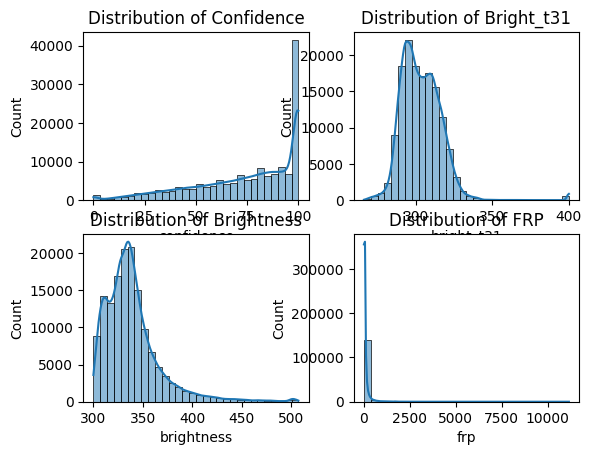

In [35]:
plt.subplot(2, 2, 1)
sns.histplot(train_df['confidence'], bins=30, kde=True)
plt.title('Distribution of Confidence')

plt.subplot(2, 2, 2)
sns.histplot(train_df['bright_t31'], bins=30, kde=True)
plt.title('Distribution of Bright_t31')

plt.subplot(2, 2, 3)
sns.histplot(train_df['brightness'], bins=30, kde=True)
plt.title('Distribution of Brightness')

plt.subplot(2, 2, 4)
sns.histplot(train_df['frp'], bins=30, kde=True)
plt.title('Distribution of FRP')

Brightness: The distribution is somewhat normal with a peak around 335. There are a few outliers with very high brightness values.

Confidence: Right-skewed with a peak near 100, indicating most observations have high confidence.

Brightness Temperature (bright_t31): Normally distributed with a peak around 300.

Fire Radiative Power (FRP): Right-skewed with many observations having low FRP and few with very high FRP, indicating outliers.

### Convert date and time columns

In [36]:
train_df['acq_date'] = pd.to_datetime(train_df['acq_date'])
train_df['acq_time'] = train_df['acq_time'].astype(str).str.zfill(4)
train_df['acq_time'] = pd.to_datetime(train_df['acq_time'], format='%H%M').dt.time

### Feature Engineering and creating interactive terms

In [37]:
train_df['acq_month'] = train_df['acq_date'].dt.month
train_df['acq_day'] = train_df['acq_date'].dt.day
train_df['acq_hour'] = pd.to_datetime(train_df['acq_time'].astype(str), format='%H:%M:%S').dt.hour
train_df['acq_minute'] = pd.to_datetime(train_df['acq_time'].astype(str), format='%H:%M:%S').dt.minute

train_df['brightness_bright_t31'] = train_df['brightness'] * train_df['bright_t31']
train_df['latitude_longitude'] = train_df['latitude'] * train_df['longitude']

I've taken month, day, hour and minute into consideration as forest fires happen at specific time of the years and month and also during the day hourse because of the heat forest fires can happen.

Creating interaction terms between features like brightness and bright_t31 or latitude and longitude can help capture relationships and patterns that may not be evident when considering each feature individually. These interactions might improve the performance of my model as it is providing additional information about how these features jointly influence the target variable. 

### Prepare features and target

In [38]:
X_train = train_df.drop(['id', 'confidence', 'acq_date', 'acq_time', 'version', 'instrument'], axis=1)
y_train = train_df['confidence']

categorical_features = ['daynight', 'satellite']
numerical_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_indices = [X_train.columns.get_loc(col) for col in categorical_features]

Removed 'id' as there was no realtion with the main task and 'version' and 'instrument' were constant. Also as said above month, day, hour and minute has been taken into consideration so no need for 'acq_date' and 'acq_time' column also

### Preprocessing

In [39]:
ct = ColumnTransformer(transformers=[
    ("cat", OneHotEncoder(), categorical_indices),
    ("num", StandardScaler(), numerical_features)
], remainder='passthrough')

X_train = ct.fit_transform(X_train)

Categorical features have been encoded and numerical features has been standardized here for preventing any further problems in training.

### Define CatBoostRegressor and hyperparameter search

In [15]:
catboost = CatBoostRegressor(random_seed=42, silent=True)

param_dist = {
    'iterations': [500, 1000, 1500],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [3, 5, 7, 10],
    'l2_leaf_reg': [1, 3, 5, 7],
    'bagging_temperature': [0, 0.5, 1],
    'border_count': [32, 64, 128]
}

random_search = RandomizedSearchCV(catboost, param_distributions=param_dist, n_iter=50, scoring='r2', cv=3, verbose=2, random_state=42, n_jobs=1)
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END bagging_temperature=0.5, border_count=64, depth=3, iterations=1000, l2_leaf_reg=7, learning_rate=0.05; total time=   2.6s
[CV] END bagging_temperature=0.5, border_count=64, depth=3, iterations=1000, l2_leaf_reg=7, learning_rate=0.05; total time=   2.5s
[CV] END bagging_temperature=0.5, border_count=64, depth=3, iterations=1000, l2_leaf_reg=7, learning_rate=0.05; total time=   2.5s
[CV] END bagging_temperature=0, border_count=128, depth=5, iterations=1000, l2_leaf_reg=7, learning_rate=0.05; total time=   3.1s
[CV] END bagging_temperature=0, border_count=128, depth=5, iterations=1000, l2_leaf_reg=7, learning_rate=0.05; total time=   3.2s
[CV] END bagging_temperature=0, border_count=128, depth=5, iterations=1000, l2_leaf_reg=7, learning_rate=0.05; total time=   3.2s
[CV] END bagging_temperature=0.5, border_count=128, depth=3, iterations=1500, l2_leaf_reg=1, learning_rate=0.05; total time=   3.5s
[CV] END bagging_temper

RandomizedSearchCV(cv=3,
                   estimator=<catboost.core.CatBoostRegressor object at 0x303ce9b80>,
                   n_iter=50, n_jobs=1,
                   param_distributions={'bagging_temperature': [0, 0.5, 1],
                                        'border_count': [32, 64, 128],
                                        'depth': [3, 5, 7, 10],
                                        'iterations': [500, 1000, 1500],
                                        'l2_leaf_reg': [1, 3, 5, 7],
                                        'learning_rate': [0.01, 0.05, 0.1]},
                   random_state=42, scoring='r2', verbose=2)

In [40]:
best_catboost = random_search.best_estimator_

Best estimator values of CatBoost model are stored in 'best_catboost' obtained from RandomizedSearchCV's hyperparameter optimization to again fine tune it with GridSearchCV.

### Refine with GridSearchCV

In [17]:
param_grid = {
    'iterations': [best_catboost.get_params()['iterations'] - 500, best_catboost.get_params()['iterations'], best_catboost.get_params()['iterations'] + 500],
    'learning_rate': [max(0.01, best_catboost.get_params()['learning_rate'] - 0.02), best_catboost.get_params()['learning_rate'], min(0.2, best_catboost.get_params()['learning_rate'] + 0.02)],
    'depth': [max(1, best_catboost.get_params()['depth'] - 2), best_catboost.get_params()['depth'], best_catboost.get_params()['depth'] + 2]
}

grid_search = GridSearchCV(catboost, param_grid=param_grid, scoring='r2', cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END .......depth=8, iterations=1000, learning_rate=0.08; total time=  22.9s
[CV] END ........depth=8, iterations=1500, learning_rate=0.1; total time=  40.8s
[CV] END ........depth=8, iterations=2000, learning_rate=0.1; total time= 1.6min
[CV] END .......depth=10, iterations=1000, learning_rate=0.1; total time= 1.7min
[CV] END ......depth=10, iterations=1500, learning_rate=0.08; total time= 2.6min
[CV] END ......depth=10, iterations=2000, learning_rate=0.08; total time= 3.4min
[CV] END ......depth=12, iterations=1000, learning_rate=0.08; total time= 3.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END .......depth=8, iterations=1000, learning_rate=0.08; total time=  22.7s
[CV] END .......depth=8, iterations=1500, learning_rate=0.08; total time=  37.2s
[CV] END .......depth=8, iterations=2000, learning_rate=0.08; total time= 1.5min
[CV] END depth=8, iterations=2000, learning_rate=0.12000000000000001; total time= 1.9min
[CV] END .......depth=10, iterations=1500, learning_rate=0.1; total time= 2.7min
[CV] END ......depth=10, iterations=2000, learning_rate=0.08; total time= 3.3min
[CV] END ......depth=12, iterations=1000, learning_rate=0.08; total time= 3.4min
[CV] END ........depth=8, iterations=1000, learning_rate=0.1; total time=  22.5s
[CV] END depth=8, iterations=1000, learning_rate=0.12000000000000001; total time=  23.4s
[CV] END depth=8, iterations=1500, learning_rate=0.12000000000000001; total time=  54.7s
[CV] END depth=8, iterations=2000, learning_rate=0.12000000000000001; total time= 1.8min
[CV] END .......depth=10, iterations=1000, learning_rate=0.1; total time= 1.7

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x303ce9b80>,
             n_jobs=-1,
             param_grid={'depth': [8, 10, 12], 'iterations': [1000, 1500, 2000],
                         'learning_rate': [0.08, 0.1, 0.12000000000000001]},
             scoring='r2', verbose=2)

In [41]:
best_model = grid_search.best_estimator_

Our model is ready to be tested out on the test set.

### Feature engineering for the test set

In [42]:
test_df['acq_date'] = pd.to_datetime(test_df['acq_date'])
test_df['acq_time'] = test_df['acq_time'].astype(str).str.zfill(4)
test_df['acq_time'] = pd.to_datetime(test_df['acq_time'], format='%H%M').dt.time
test_df['acq_month'] = test_df['acq_date'].dt.month
test_df['acq_day'] = test_df['acq_date'].dt.day
test_df['acq_hour'] = pd.to_datetime(test_df['acq_time'].astype(str), format='%H:%M:%S').dt.hour
test_df['acq_minute'] = pd.to_datetime(test_df['acq_time'].astype(str), format='%H:%M:%S').dt.minute
test_df['brightness_bright_t31'] = test_df['brightness'] * test_df['bright_t31']
test_df['latitude_longitude'] = test_df['latitude'] * test_df['longitude']

X_test = test_df.drop(['id', 'acq_date', 'acq_time', 'instrument', 'version'], axis=1)
X_test = ct.transform(X_test)

The test set is made to look the same as the training set as the model will be requiring the data in those order and format for result.

### Predictions and saving the data produced for submission

In [51]:
y_pred_test = best_model.predict(X_test)

output = pd.DataFrame({'id': test_df['id'], 'confidence': y_pred_test})
output.to_csv('changed10.csv', index=False)

Our model predicts the confidence for the test data and is ready to be stored in another file with the two columns as asked in contest.

### Model performance evaluation on training data

In [44]:
y_pred_train = best_model.predict(X_train)
train_mse = mean_squared_error(y_train, y_pred_train)
train_r2 = r2_score(y_train, y_pred_train)

print(f'Train MSE: {train_mse}')
print(f'Train R^2: {train_r2}')

Train MSE: 91.3480905081857
Train R^2: 0.8540835332218937


These predictions are made on the training set to make sure the model is not overfitting.

### Feature Importance

In [49]:
feature_importances = best_model.get_feature_importance()
feature_names = numerical_features + list(ct.transformers_[0][1].get_feature_names_out(categorical_features))

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values('Importance', ascending=False)

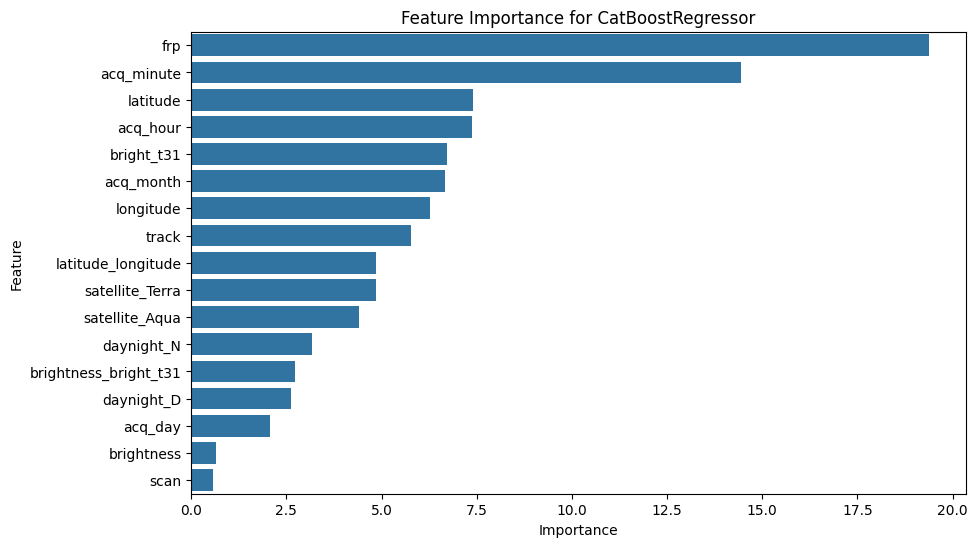

In [46]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance for CatBoostRegressor')
plt.show()

Fire Radiative Power has been considered as the main feature in predicting the forest fire as it should be, being the main indicator towards fire. But the reason why it's done to know which features are having the most and least impact on the results.

### Visualization of Predictions vs Actuals

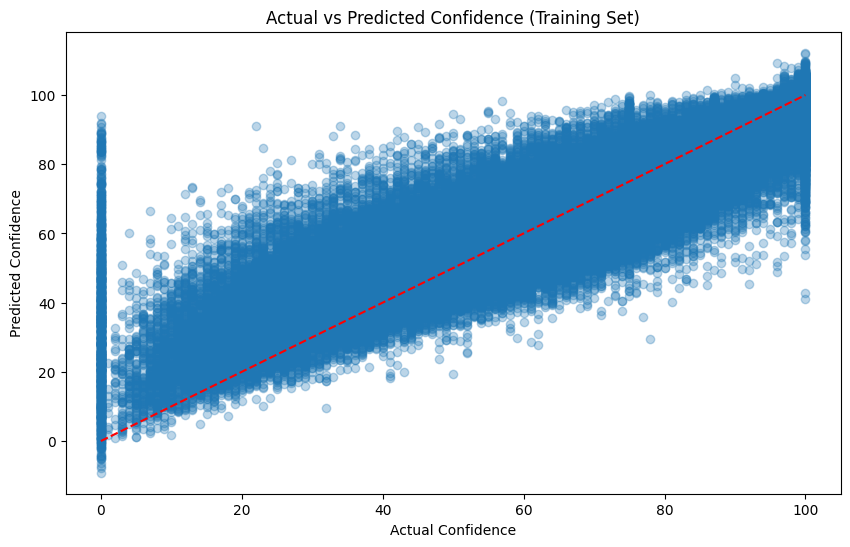

In [47]:
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_pred_train, alpha=0.3)
plt.plot([0, 100], [0, 100], '--r')
plt.xlabel('Actual Confidence')
plt.ylabel('Predicted Confidence')
plt.title('Actual vs Predicted Confidence (Training Set)')
plt.show()

This will help us know how well the model predicts the confidence of it's own data set on which it was trained.

### Distribution of predictions

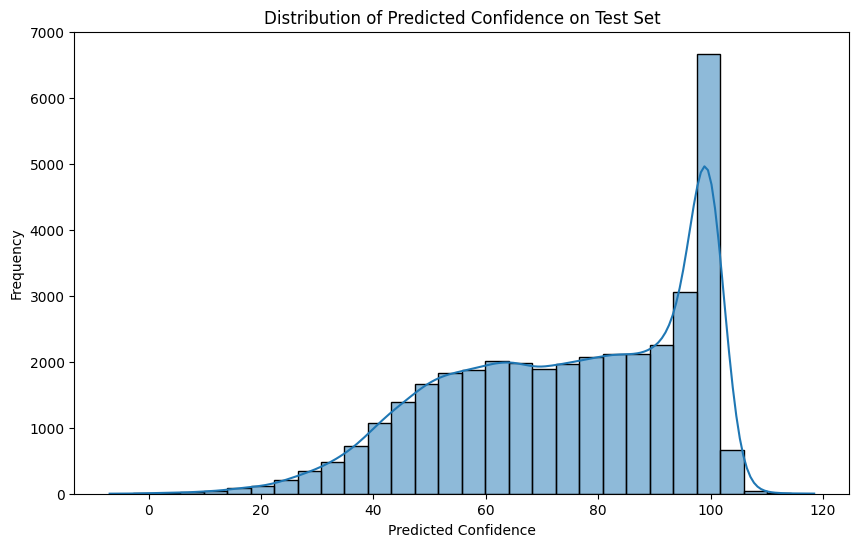

In [48]:
plt.figure(figsize=(10, 6))
sns.histplot(y_pred_test, bins=30, kde=True)
plt.title('Distribution of Predicted Confidence on Test Set')
plt.xlabel('Predicted Confidence')
plt.ylabel('Frequency')
plt.show()

The graph is skewed towards right telling there's high confidence in all the observations provided by the test set.